# Polars groupby on parquet data 2021+, eager vs lazy

In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

%load_ext autoreload
%autoreload 2

display(f"Pandas {pd.__version__}, Polars {pl.__version__}")

from cell_profiler import cell_profiler as cp

%start_cell_profiler


def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = "Unknown"
    try:
        num_bytes = df.estimated_size()  # try Polars
        df_type = "Polars"
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum()  # try Pandas
        df_type = "Pandas"
    except AttributeError:
        pass
    display(
        f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes"
    )

'Pandas 2.0.1, Polars 0.17.10'

In [1] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 207.0 MiB


In [2]:
dfple = pl.read_parquet("../test_result_2021on.parquet")

In [2] used 12775.3 MiB RAM in 2.96s (system mean cpu 33%, single max cpu 39%), peaked 0.0 MiB above final usage, current RAM usage now 12982.2 MiB


Notes from Ritchie via: https://pola-rs.github.io/polars-book/user-guide/lazy/query_plan/ via https://en.wikipedia.org/wiki/Relational_algebra

```
Pi 2/14 means we only select 2/14 columns.

Pi is relational algebra for projection (column selection)

Sigma is relational algebra for selection (row filtering)
```

In [3]:
show_rows_memory(dfple)

'Polars df with 82,012,245 rows, 11.14 GB bytes'

In [3] used 0.0 MiB RAM in 0.14s (system mean cpu 8%, single max cpu 29%), peaked 0.0 MiB above final usage, current RAM usage now 12982.3 MiB


In [4]:
dfple.lazy().groupby(by="make").agg("cylinder_capacity")

In [4] used 0.0 MiB RAM in 0.14s (system mean cpu 5%, single max cpu 17%), peaked 0.0 MiB above final usage, current RAM usage now 12982.3 MiB


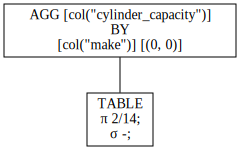

In [5] used 1.0 MiB RAM in 0.13s (system mean cpu 5%, single max cpu 40%), peaked 0.0 MiB above final usage, current RAM usage now 12983.2 MiB


In [5]:
dfple.lazy().groupby(by="make").agg("cylinder_capacity").show_graph()

In [6]:
print(dfple.lazy().groupby(by="make").agg("cylinder_capacity").explain(optimized=False))

AGGREGATE
	[col("cylinder_capacity")] BY [col("make")] FROM
	DF ["test_id", "vehicle_id", "test_date", "test_class_id"]; PROJECT */14 COLUMNS; SELECTION: "None"
In [6] used 0.0 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 25%), peaked 0.0 MiB above final usage, current RAM usage now 12983.2 MiB


In [7]:
dfple.lazy().groupby(by="make").agg("cylinder_capacity").profile()

(shape: (12_290, 2)
 ┌──────────────────────┬────────────────────┐
 │ make                 ┆ cylinder_capacity  │
 │ ---                  ┆ ---                │
 │ str                  ┆ list[i64]          │
 ╞══════════════════════╪════════════════════╡
 │ HONDA TRANSALPXL600V ┆ [583, 583]         │
 │ MITSUOKA VEIWT       ┆ [1400, 1400, 1400] │
 │ BMW320I SE 2.2L      ┆ [2171, 2171, 2171] │
 │ JIANSHE              ┆ [124, 125, … 125]  │
 │ …                    ┆ …                  │
 │ SUBURU               ┆ [1990, 2000]       │
 │ ARNOTT               ┆ [1100]             │
 │ VIJAY SUPER GP 150   ┆ [150, 349, 150]    │
 │ BURSNTER             ┆ [2287, 2287, 2287] │
 └──────────────────────┴────────────────────┘,
 shape: (2, 3)
 ┌───────────────┬───────┬─────────┐
 │ node          ┆ start ┆ end     │
 │ ---           ┆ ---   ┆ ---     │
 │ str           ┆ u64   ┆ u64     │
 ╞═══════════════╪═══════╪═════════╡
 │ optimization  ┆ 0     ┆ 30      │
 │ groupby(make) ┆ 30    ┆ 3734973 │


In [7] used 728.7 MiB RAM in 3.84s (system mean cpu 30%, single max cpu 100%), peaked 3349.9 MiB above final usage, current RAM usage now 13711.9 MiB


In [8]:
%%time
result = (
    dfple.filter(pl.col("cylinder_capacity").is_not_null())
    .groupby(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
)
result[:3]

CPU times: user 31.2 s, sys: 21.3 s, total: 52.5 s
Wall time: 5.83 s


make,median,count
str,f64,u32
"""TESLA""",0.0,16
"""VECTRIX""",4.0,13
"""LEEWAY C8""",49.0,14


In [8] used 3272.4 MiB RAM in 5.93s (system mean cpu 62%, single max cpu 100%), peaked 21442.4 MiB above final usage, current RAM usage now 16984.3 MiB


In [ ]:
# note collect(streaming=True) same result

In [9]:
%%time
result = (
    dfple.lazy()
    .filter(pl.col("cylinder_capacity").is_not_null())
    .groupby(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
    .collect()
)

CPU times: user 18 s, sys: 4.62 s, total: 22.6 s
Wall time: 2.96 s


make,median,count
str,f64,u32
"""TESLA""",0.0,16
"""VECTRIX""",4.0,13
"""PUCH""",49.0,201


In [9] used -1559.2 MiB RAM in 3.06s (system mean cpu 50%, single max cpu 100%), peaked 4424.3 MiB above final usage, current RAM usage now 15425.1 MiB


In [ ]:
result[:3]

In [10]:
result.filter(pl.col("make") == "ROLLS ROYCE")

make,median,count
str,f64,u32
"""ROLLS ROYCE""",6749.0,11741


In [10] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 23%), peaked 0.0 MiB above final usage, current RAM usage now 15425.1 MiB


In [11]:
assert result.filter(pl.col("make") == "ROLLS ROYCE")["median"].item() == 6749.0
assert result.filter(pl.col("make") == "ROLLS ROYCE")["count"].item() == 11741.0

In [11] used 0.0 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 57%), peaked 0.0 MiB above final usage, current RAM usage now 15425.1 MiB


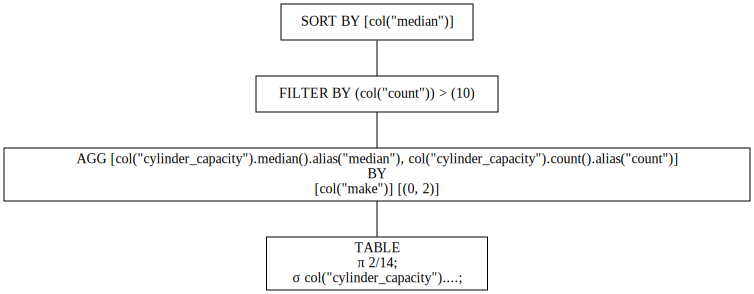

In [12] used 0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 15425.1 MiB


In [12]:
# figsize in show_graph
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").show_graph()

In [13]:
print(
    dfple.lazy()
    .filter(pl.col("cylinder_capacity").is_not_null())
    .groupby(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
    .explain(optimized=False)
)

SORT BY [col("median")]
  FILTER [(col("count")) > (10)] FROM
  AGGREGATE
  	[col("cylinder_capacity").median().alias("median"), col("cylinder_capacity").count().alias("count")] BY [col("make")] FROM
  	FILTER col("cylinder_capacity").is_not_null() FROMDF ["test_id", "vehicle_id", "test_date", "test_class_id"]; PROJECT */14 COLUMNS; SELECTION: "None"
In [13] used 0.0 MiB RAM in 0.10s (system mean cpu 6%, single max cpu 40%), peaked 0.0 MiB above final usage, current RAM usage now 15425.1 MiB


In [14]:
print(
    dfple.lazy()
    .filter(pl.col("cylinder_capacity").is_not_null())
    .groupby(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
    .explain()
)

SORT BY [col("median")]
  FILTER [(col("count")) > (10)] FROM
  AGGREGATE
  	[col("cylinder_capacity").median().alias("median"), col("cylinder_capacity").count().alias("count")] BY [col("make")] FROM
  	DF ["test_id", "vehicle_id", "test_date", "test_class_id"]; PROJECT 2/14 COLUMNS; SELECTION: "col(\"cylinder_capacity\").is_not_null()"
In [14] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 15425.1 MiB


In [15]:
# .profile() only exists for Lazy dataframe
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").profile()

(shape: (1_275, 3)
 ┌──────────────────┬─────────┬───────┐
 │ make             ┆ median  ┆ count │
 │ ---              ┆ ---     ┆ ---   │
 │ str              ┆ f64     ┆ u32   │
 ╞══════════════════╪═════════╪═══════╡
 │ TESLA            ┆ 0.0     ┆ 16    │
 │ VECTRIX          ┆ 4.0     ┆ 13    │
 │ PHILLIPS         ┆ 49.0    ┆ 12    │
 │ LINTEX           ┆ 49.0    ┆ 79    │
 │ …                ┆ …       ┆ …     │
 │ LEYLAND NATIONAL ┆ 10450.0 ┆ 15    │
 │ NEOPLAN          ┆ 12609.5 ┆ 18    │
 │ KENWORTH         ┆ 14000.0 ┆ 11    │
 │ SETRA            ┆ 14618.0 ┆ 19    │
 └──────────────────┴─────────┴───────┘,
 shape: (4, 3)
 ┌──────────────────────────────────┬─────────┬─────────┐
 │ node                             ┆ start   ┆ end     │
 │ ---                              ┆ ---     ┆ ---     │
 │ str                              ┆ u64     ┆ u64     │
 ╞══════════════════════════════════╪═════════╪═════════╡
 │ optimization                     ┆ 0       ┆ 1144120 │
 │ groupby(make) 

In [15] used -1058.4 MiB RAM in 3.02s (system mean cpu 40%, single max cpu 100%), peaked 4246.5 MiB above final usage, current RAM usage now 14366.7 MiB


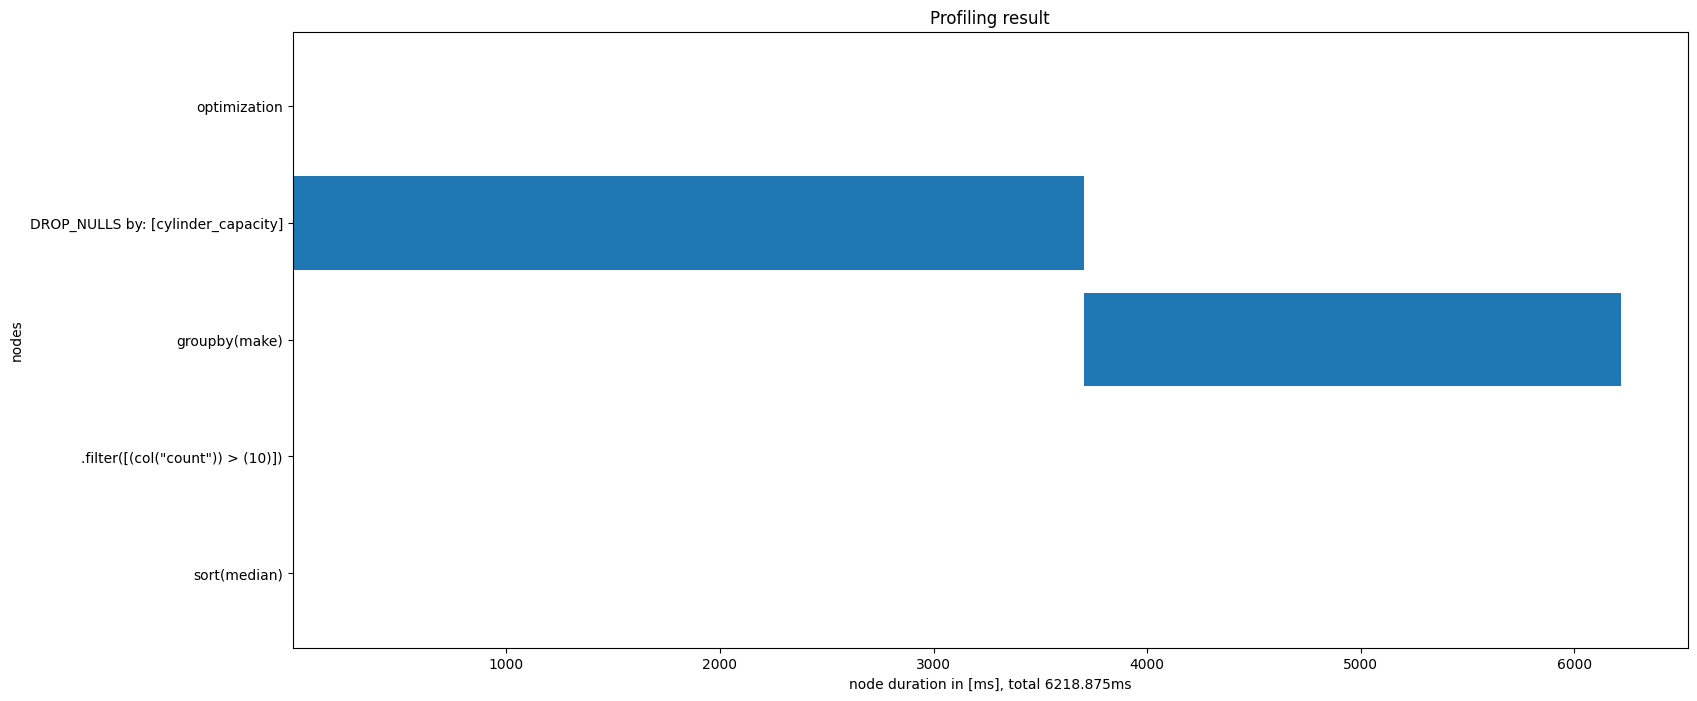

(shape: (1_275, 3)
 ┌──────────────────┬─────────┬───────┐
 │ make             ┆ median  ┆ count │
 │ ---              ┆ ---     ┆ ---   │
 │ str              ┆ f64     ┆ u32   │
 ╞══════════════════╪═════════╪═══════╡
 │ TESLA            ┆ 0.0     ┆ 16    │
 │ VECTRIX          ┆ 4.0     ┆ 13    │
 │ LINTEX HT50QT-16 ┆ 49.0    ┆ 12    │
 │ NANFANG NF50-A   ┆ 49.0    ┆ 86    │
 │ …                ┆ …       ┆ …     │
 │ LEYLAND NATIONAL ┆ 10450.0 ┆ 15    │
 │ NEOPLAN          ┆ 12609.5 ┆ 18    │
 │ KENWORTH         ┆ 14000.0 ┆ 11    │
 │ SETRA            ┆ 14618.0 ┆ 19    │
 └──────────────────┴─────────┴───────┘,
 shape: (5, 3)
 ┌───────────────────────────────────┬─────────┬─────────┐
 │ node                              ┆ start   ┆ end     │
 │ ---                               ┆ ---     ┆ ---     │
 │ str                               ┆ u64     ┆ u64     │
 ╞═══════════════════════════════════╪═════════╪═════════╡
 │ optimization                      ┆ 0       ┆ 5       │
 │ DROP_NUL

In [16] used 2962.5 MiB RAM in 6.42s (system mean cpu 53%, single max cpu 100%), peaked 19596.2 MiB above final usage, current RAM usage now 17329.2 MiB


In [16]:
# .profile() only exists for Lazy dataframe
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").profile(
    type_coercion=False,
    predicate_pushdown=False,
    projection_pushdown=False,
    simplify_expression=False,
    slice_pushdown=False,
    common_subplan_elimination=False,
    show_plot=True,
)

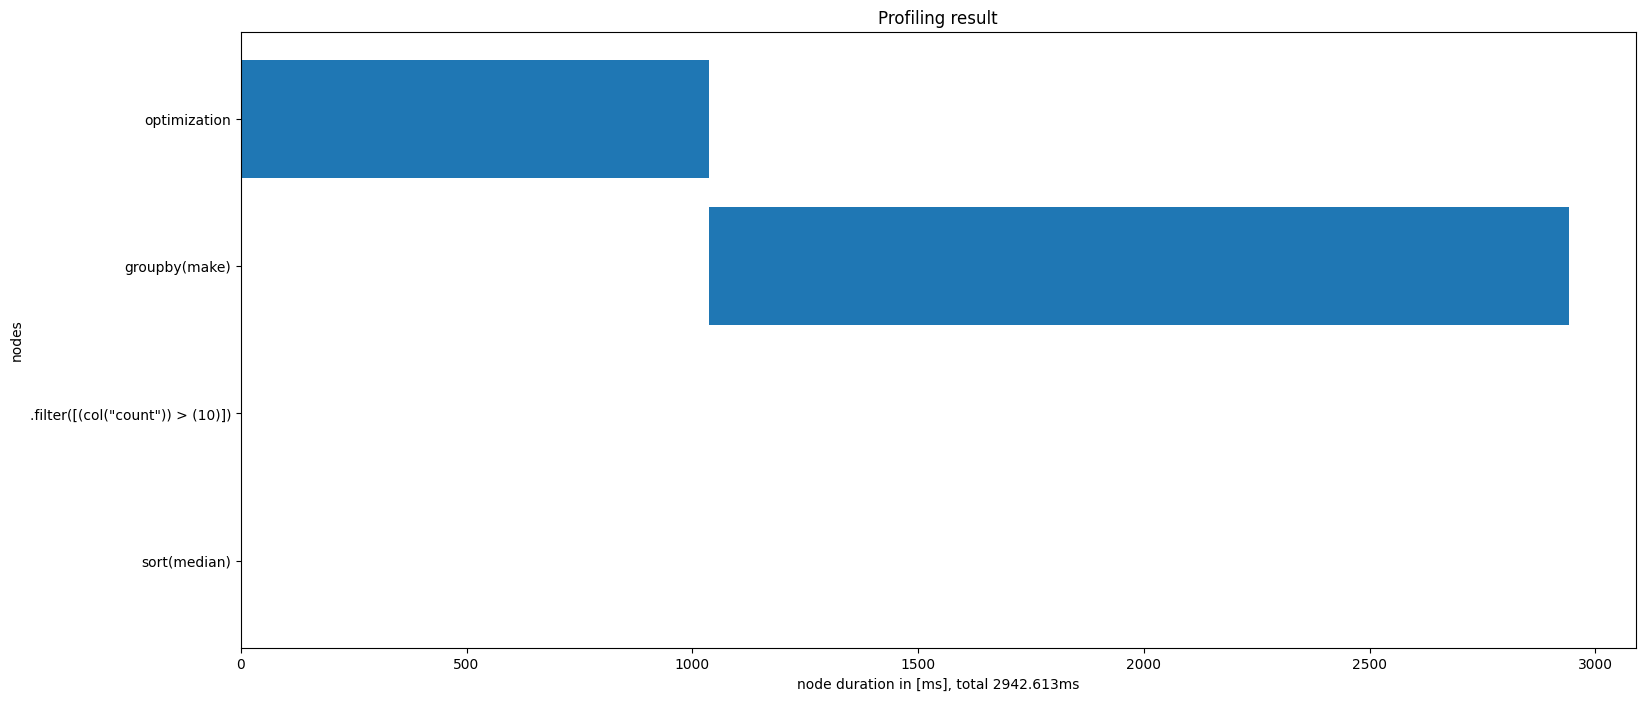

(shape: (1_275, 3)
 ┌──────────────────────┬─────────┬───────┐
 │ make                 ┆ median  ┆ count │
 │ ---                  ┆ ---     ┆ ---   │
 │ str                  ┆ f64     ┆ u32   │
 ╞══════════════════════╪═════════╪═══════╡
 │ TESLA                ┆ 0.0     ┆ 16    │
 │ VECTRIX              ┆ 4.0     ┆ 13    │
 │ YAMASAKI YM50-D      ┆ 49.0    ┆ 13    │
 │ DIRECTBIKES DB50QT-A ┆ 49.0    ┆ 16    │
 │ …                    ┆ …       ┆ …     │
 │ LEYLAND NATIONAL     ┆ 10450.0 ┆ 15    │
 │ NEOPLAN              ┆ 12609.5 ┆ 18    │
 │ KENWORTH             ┆ 14000.0 ┆ 11    │
 │ SETRA                ┆ 14618.0 ┆ 19    │
 └──────────────────────┴─────────┴───────┘,
 shape: (4, 3)
 ┌──────────────────────────────────┬─────────┬─────────┐
 │ node                             ┆ start   ┆ end     │
 │ ---                              ┆ ---     ┆ ---     │
 │ str                              ┆ u64     ┆ u64     │
 ╞══════════════════════════════════╪═════════╪═════════╡
 │ optimization

In [17] used -1805.8 MiB RAM in 3.12s (system mean cpu 40%, single max cpu 100%), peaked 4422.2 MiB above final usage, current RAM usage now 15523.4 MiB


In [17]:
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").profile(show_plot=True)

# Resample

In [18]:
dfple.head()

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[ns],i64,str,str,i64,str,str,str,str,str,i64,datetime[ns]
334683447,634775234,2022-01-01 00:00:00,4,"""NT""","""P""",227219,"""E""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1497,2008-01-17 00:00:00
586095521,1220215709,2022-01-01 00:00:00,4,"""NT""","""P""",136552,"""CR""","""TOYOTA""","""PRIUS""","""GREY""","""Hybrid Electri…",1798,2013-11-29 00:00:00
960974211,1315791989,2022-01-01 00:00:00,4,"""NT""","""F""",129847,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00
1041792341,1144451355,2022-01-01 00:00:00,4,"""NT""","""P""",123133,"""TW""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1496,2016-11-21 00:00:00
1587264975,1315791989,2022-01-01 00:00:00,4,"""RT""","""P""",129848,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00


In [18] used 0.0 MiB RAM in 0.10s (system mean cpu 4%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 15523.4 MiB


In [19]:
dfple = pl.read_parquet("../test_result_2021on.parquet")

In [19] used 12625.6 MiB RAM in 2.60s (system mean cpu 53%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 28149.0 MiB


In [20]:
# dfple = dfple.with_columns(pl.col('test_date').dt.year().alias('test_year'))
#dfple = dfple.with_columns((pl.col("test_result") == pl.lit("P")).alias("passed"))
# dfple.sample(10000).with_columns((pl.col('cylinder_capacity')>1000).alias('other'))

In [20] used -165.2 MiB RAM in 0.52s (system mean cpu 7%, single max cpu 100%), peaked 165.3 MiB above final usage, current RAM usage now 27983.8 MiB


In [21]:
# dfple.head(10000).sort(pl.col('test_date')).groupby_dynamic('test_date', every='1w').agg(pl.col('test_type')).mean()

In [21] used 0.0 MiB RAM in 0.10s (system mean cpu 11%, single max cpu 23%), peaked 0.0 MiB above final usage, current RAM usage now 27983.8 MiB


In [22]:
dfple = dfple.with_columns((pl.col("test_result") == pl.lit("P")). \
                           alias("passed"))
result = (
    dfple.sort(pl.col("test_date"))
    .groupby_dynamic("test_date", every="1w")
    .agg(pl.col("passed").sum())
)

In [22] used -846.3 MiB RAM in 8.44s (system mean cpu 52%, single max cpu 100%), peaked 25479.2 MiB above final usage, current RAM usage now 27137.5 MiB


Text(2021-03-26 00:00:00, 200000, 'April Lockdown\neffect from 2020?')

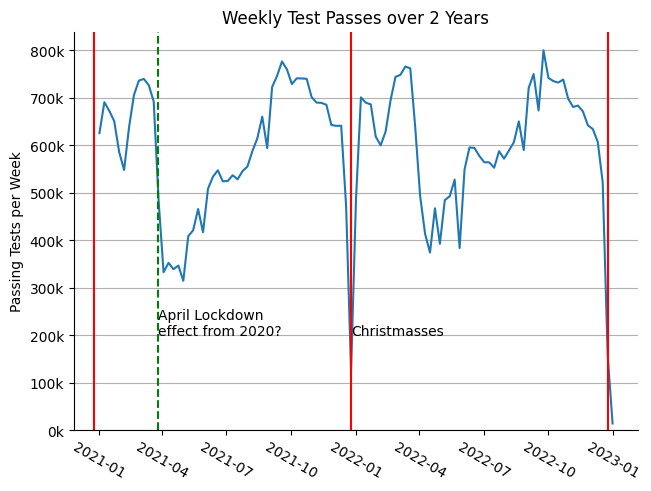

In [23] used 2.7 MiB RAM in 0.30s (system mean cpu 11%, single max cpu 82%), peaked 0.0 MiB above final usage, current RAM usage now 27140.2 MiB


In [23]:
from simpler_mpl import set_common_mpl_styles, set_commas

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(result["test_date"], result["passed"])  # , marker='o')
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x/1000):,}k")
plt.xticks(rotation=-30)
set_common_mpl_styles(
    ax, title="Weekly Test Passes over 2 Years", ymin=0, ylabel="Passing Tests per Week"
)  # , xlabel="Weekly 2021-2022")
ax.axvline(pd.to_datetime("2020-12-25"), color="red")
ax.axvline(pd.to_datetime("2021-12-25"), color="red")
ax.annotate("Christmasses", (pd.to_datetime("2021-12-25"), 200000))
ax.axvline(pd.to_datetime("2022-12-25"), color="red")
# ax.annotate('Christmas', (pd.to_datetime('2022-09-10'), 200000)) # horrid offset for alignment
ax.axvline(pd.to_datetime("2021-03-26"), color="green", linestyle="--")
ax.annotate("April Lockdown\neffect from 2020?", (pd.to_datetime("2021-03-26"), 200000))

## Resample but on larger dataset

In [24]:
dfpll = pl.scan_parquet("../test_result.parquet/*.parquet")
dfpll.select(pl.count()).collect().item()

639506962

In [24] used -210.3 MiB RAM in 4.95s (system mean cpu 32%, single max cpu 100%), peaked 8724.7 MiB above final usage, current RAM usage now 26929.8 MiB


In [25]:
import datetime

# 82012876
dfpll.filter(pl.col("test_date") > datetime.datetime(2021, 1, 1)).select(
    pl.count()
).collect()

count
u32
82012245


In [25] used -162.5 MiB RAM in 3.68s (system mean cpu 62%, single max cpu 100%), peaked 1843.2 MiB above final usage, current RAM usage now 26767.4 MiB


In [26]:
result_lz = (
    dfpll.filter(pl.col("test_date") > datetime.datetime(2018, 1, 1))
    .with_columns((pl.col("test_result") == pl.lit("P")).alias("passed"))
    .sort(pl.col("test_date"))
    .groupby_dynamic("test_date", every="1w")
    .agg(pl.col("passed").sum())
    .collect()
)

In [26] used -5.4 MiB RAM in 11.73s (system mean cpu 36%, single max cpu 100%), peaked 9327.3 MiB above final usage, current RAM usage now 26761.9 MiB


Text(2020-04-01 00:00:00, 100000, 'Lockdown\nknock-on')

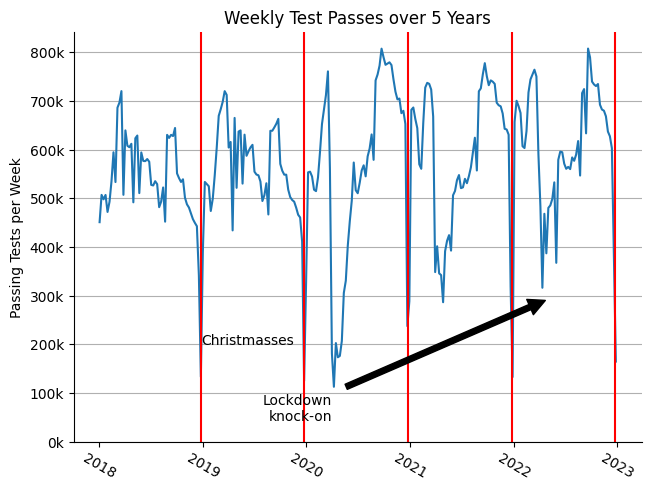

In [27] used 1.0 MiB RAM in 0.30s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 26762.9 MiB


In [27]:
from simpler_mpl import set_common_mpl_styles, set_commas

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(result_lz["test_date"], result_lz["passed"])  # , marker='o')
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x/1000):,}k")
plt.xticks(rotation=-30)
set_common_mpl_styles(
    ax, title="Weekly Test Passes over 5 Years", ymin=0, ylabel="Passing Tests per Week"
)  # , xlabel="Weekly 2021-2022")
for dt_str in ["2018-12-25", "2019-12-25", "2020-12-25", "2021-12-25", "2022-12-25"]:
    ax.axvline(pd.to_datetime(dt_str), color="red")
ax.annotate(
    "Christmasses", (pd.to_datetime("2018-12-25"), 200000)
)  # horrid offset for alignment
ax.annotate(
    "Lockdown\nknock-on",
    (pd.to_datetime("2022-06"), 300000),
    # textcoords='axes fraction',
    xytext=(pd.to_datetime("2020-04"), 100000),
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="right",
    verticalalignment="top",
)